In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('cleaned_data.csv')
df.head(3)

,DBN,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
0,01M292,29,355.0,404.0,363.0,1122.0,129.028846,197.038462,153.45,Total Cohort,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260,1
1,01M448,91,383.0,423.0,366.0,1172.0,39.000000,49.000000,10.00,Total Cohort,...,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797,1
2,01M450,70,377.0,402.0,370.0,1149.0,19.000000,21.000000,153.45,Total Cohort,...,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041,1


# SAT Scores of Each School

In [4]:
from geopy.geocoders import Nominatim
import requests
import folium

address = 'New York, New York, USA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City is 40.7127281, -74.0060152.


In [5]:
ncluster = 50

bins = list(np.linspace(df.sat_score.min(), df.sat_score.max(), num=ncluster))
df['binned_sat_score'] = np.searchsorted(bins, df['sat_score'])

In [6]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(ncluster)
ys = [i + x + (i*x)**2 for i in range(ncluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# create map of Cape Town using latitude and longitude values
map_edu = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='CartoDB positron')


# generate a title above the map
# from https://github.com/python-visualization/folium/issues/1202
map_title = "SAT score of each NYC high school"
note = 'warm color coresponds to higher SAT score'
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             <h4 align="center" style="font-size:12px"><b>{}</b></h4>
             '''.format(map_title, note)
map_edu.get_root().html.add_child(folium.Element(title_html))


# add markers to the map
markers_colors = []
for lat, lng, school_name,binned_sat_score, dist, nta, sat in zip(df['lat'], df['lon'],df['school_name'],df['binned_sat_score'],df['school_dist'],df['NTA'],df['sat_score']):
    label = folium.Popup(school_name +". District: "+str(dist)+
                ". Neighborhood: {}".format(nta)+
                ". Average SAT score: {}".format(sat), parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=rainbow[int(binned_sat_score)-1],
        fill=True,
        fill_color=rainbow[int(binned_sat_score)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_edu)  
    
map_edu

In [7]:
path='nyc_edu.html'
map_edu.save(path)

In [6]:
correlations = df.corr()['sat_score'].sort_values(ascending = False)
correlations[:30]

sat_score                               1.000000
binned_sat_score                        0.999273
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Total Regents - % of cohort             0.667603
white_per                               0.620718
Total Grads - % of cohort               0.584234
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Total Regents - % of grads              0.494732
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS /

- SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score


# Number of Students vs. SAT Score

In [7]:
correlations[['total_enrollment','total_students','N_s','N_p','N_t','Total Exams Taken', 'NUMBER OF SECTIONS']]

total_enrollment      0.367857
total_students        0.407827
N_s                   0.423463
N_p                   0.421530
N_t                   0.291463
Total Exams Taken     0.514333
NUMBER OF SECTIONS    0.362673
Name: sat_score, dtype: float64

- total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
- Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.

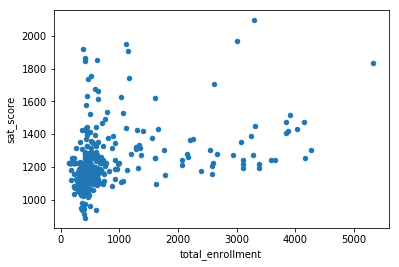

In [8]:
df.plot.scatter(x="total_enrollment", y="sat_score");

# Percentage of English Language Learners vs. SAT Score

In [9]:
low_enrollment = df[df['total_enrollment']<1000]
low_enrollment = low_enrollment[df['sat_score']<1000]
low_enrollment['school_name']

/Users/jacquelinewong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


91                  International Community High School
125                 Academy for Language and Technology
126                     Bronx International High School
139               Kingsbridge International High School
141               International School for Liberal Arts
176    Pan American International High School at Monroe
179                       High School of World Cultures
188                  Brooklyn International High School
225       International High School at Prospect Heights
237                          It Takes a Village Academy
253                           Multicultural High School
286              Pan American International High School
Name: school_name, dtype: object

Most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment. 

-0.3987497322085199


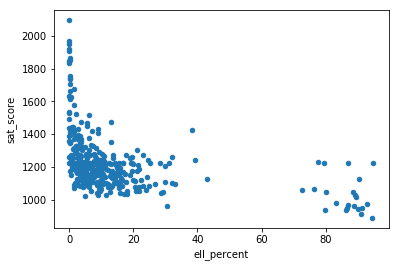

In [10]:
print(correlations['ell_percent'])
df.plot.scatter(x="ell_percent", y="sat_score");

- The percentage of English language learners at the school (ell_percent) has a negative correlation with SAT scores.

In [11]:
high_ell = df[df['ell_percent']>60]
high_ell = high_ell[df['sat_score']<1000]
high_ell['school_name']

/Users/jacquelinewong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


91                  International Community High School
125                 Academy for Language and Technology
126                     Bronx International High School
139               Kingsbridge International High School
141               International School for Liberal Arts
176    Pan American International High School at Monroe
179                       High School of World Cultures
188                  Brooklyn International High School
225       International High School at Prospect Heights
253                           Multicultural High School
286              Pan American International High School
Name: school_name, dtype: object

Apart from `It Takes a Village Academy`, `high_ell['school_name']` is the same as `low_enrollment['school_name']`

We once again prove that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment.

In [12]:
districts = df.groupby("school_dist").agg(np.mean)
# Reset the index of districts, making school_dist a column again.
districts.reset_index(inplace=True)

In [13]:
# from https://github.com/TimAlbers/Projects/tree/master/


import branca.colormap as cm

# set a simple baselayer and zoom-in on NY
map_ell = folium.Map(location=[40.693943, -73.985880], 
                        #width=500,
                        #height=800,
                        zoom_start=11,
                        tiles='CartoDB positron')

# generate a title above the map
# from https://github.com/python-visualization/folium/issues/1202
map_title = "% English language learners and SAT score by school district"
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(map_title)
map_ell.get_root().html.add_child(folium.Element(title_html))

# select column names of the viz parameters
size_parameter = "ell_percent"
color_parameter = "sat_score"

# generate a colormap to shade the cirles on the map
# from https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
start_col_val = districts[color_parameter].min()
end_col_val = districts[color_parameter].max()
start_col_hex = "#fc8d59"
end_col_hex = "#91cf60"
colormap = cm.LinearColormap(colors=[start_col_hex,
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )
colormap.caption = "SAT scores"

# create a circle for each school district
for index, row in districts.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  fill=True,
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter]*50,
                  weight=2,
                  tooltip="District "+str(row["school_dist"])+
                      " <br> Avg. SAT score: {:.1f}".format(row[color_parameter])+
                      " <br> % of English language learners: {:.0f}".format(row[size_parameter])
                 ).add_to(map_ell)

# add a legend
map_ell.add_child(colormap)
    
# display the map
map_ell

Based on the map above, it's easy to uncover that school with higher SAT scores (green color) tend to have smaller percentage of English language learners (smaller circle), and vice versa.

# Gender vs. SAT Score

female_per    0.112108
female_num    0.388631
male_per     -0.112062
male_num      0.325520
Name: sat_score, dtype: float64


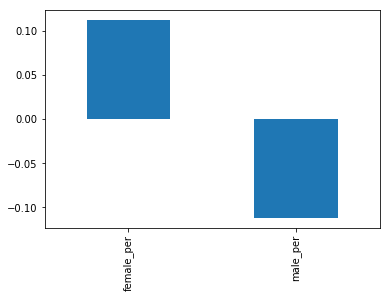

In [14]:
print(correlations[['female_per','female_num', 'male_per', 'male_num']])

correlations[['female_per','male_per']].plot.bar();

- Both the male_num and the female_num correlate positively with SAT score. However, while the percentage of females (female_per) correlates positively, male_per does negatively.

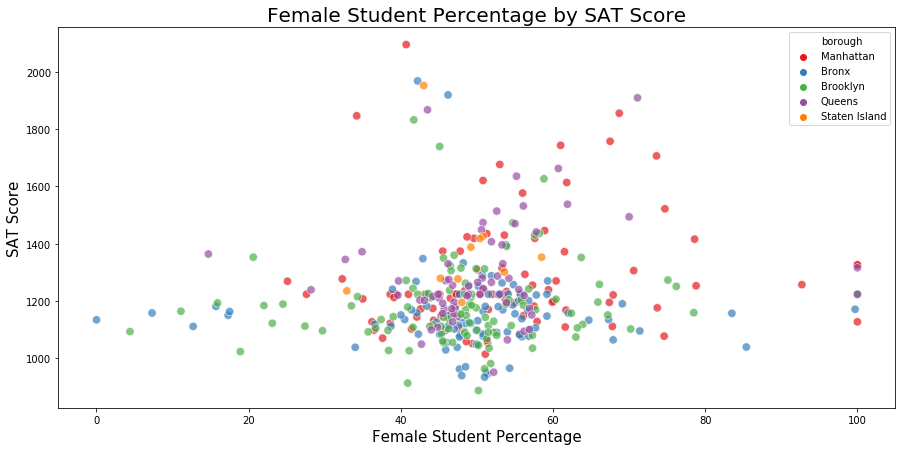

In [15]:
fig = plt.figure(figsize=(15,7))

cmap = sns.cubehelix_palette(dark=.5, light=.6, as_cmap=True)
ax = sns.scatterplot(x="female_per", y="sat_score",
                    hue="borough", 
                    palette="Set1",
                    s=70,
                    alpha=0.7,
                    data=df)
ax.set_title("Female Student Percentage by SAT Score", fontsize=20)
ax.set_xlabel("Female Student Percentage", fontsize=15)
ax.set_ylabel("SAT Score", fontsize=15)
plt.show()

# Survey Fields vs. SAT Score

In [16]:
survey_fields = [
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

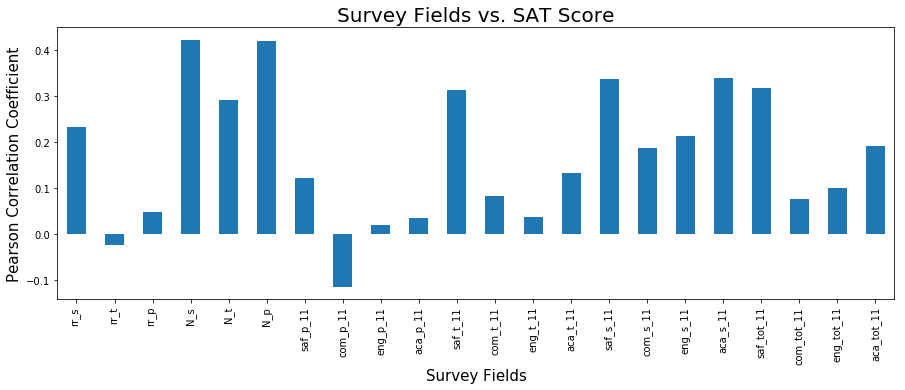

In [17]:
fig = plt.figure(figsize=(15,5))

ax = correlations[survey_fields].plot.bar()

ax.set_title("Survey Fields vs. SAT Score", fontsize=20)
ax.set_xlabel("Survey Fields", fontsize=15)
ax.set_ylabel('Pearson Correlation Coefficient', fontsize=15)
plt.show()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

### Student Perceived Safety vs. SAT Score

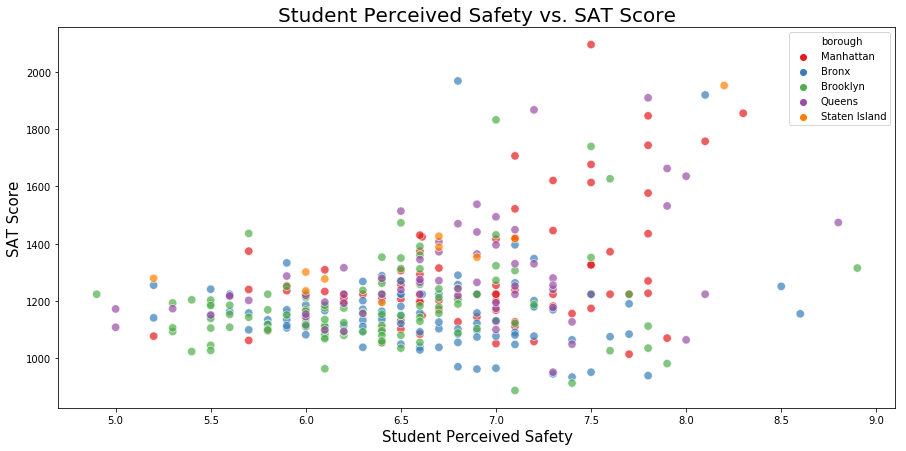

In [18]:
fig = plt.figure(figsize=(15,7))

cmap = sns.cubehelix_palette(dark=.5, light=.6, as_cmap=True)
ax = sns.scatterplot(x="saf_s_11", y="sat_score",
                    hue="borough", 
                    palette="Set1",
                    s=70,
                    alpha=0.7,
                    data=df)

ax.set_title("Student Perceived Safety vs. SAT Score", fontsize=20)
ax.set_xlabel("Student Perceived Safety", fontsize=15)
ax.set_ylabel('SAT Score', fontsize=15)
plt.show()

# Race vs. SAT Score

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


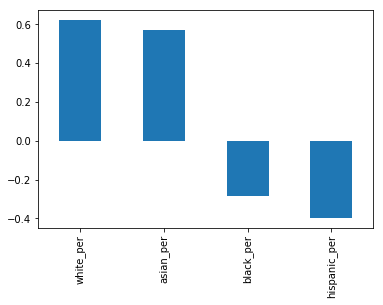

In [19]:
print(correlations[['white_per','asian_per','black_per','hispanic_per']])
correlations[['white_per','asian_per','black_per','hispanic_per']].plot.bar();

- There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).

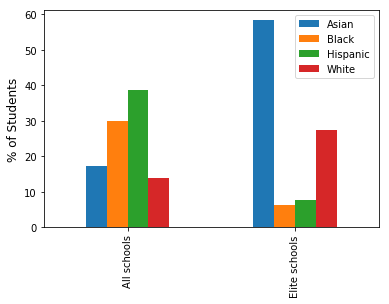

In [20]:
num_race = ['asian_num', 'black_num', 'hispanic_num', 'white_num']
high_sat = df["sat_score"] > 1800

race_dist = pd.DataFrame(data=[df.loc[:, num_race].sum()/df.loc[:, num_race].sum().sum(),
                               df.loc[high_sat, num_race].sum()/df.loc[high_sat, num_race].sum().sum()],
                         index=["All schools", "Elite schools"])*100

race_dist.columns = ["Asian","Black","Hispanic", "White"]


race_dist.plot.bar().set_ylabel('% of Students', fontsize=12);

# AP Exam Scores vs SAT Scores

In [21]:
correlations[['AP Test Takers ','Total Exams Taken','Number of Exams with scores 3 4 or 5']]

AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Name: sat_score, dtype: float64

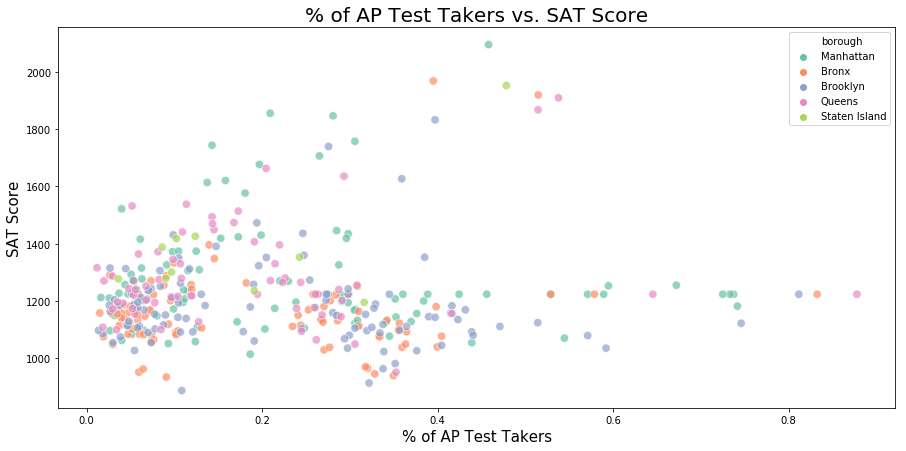

In [22]:
df['ap_per']=df['AP Test Takers ']/df['total_enrollment']

fig = plt.figure(figsize=(15,7))

cmap = sns.cubehelix_palette(dark=.5, light=.6, as_cmap=True)
ax = sns.scatterplot(x="ap_per", y="sat_score",
                    hue="borough", 
                    palette="Set2",
                    s=70,
                    alpha=0.7,
                    data=df)

ax.set_title("% of AP Test Takers vs. SAT Score", fontsize=20)
ax.set_xlabel("% of AP Test Takers", fontsize=15)
ax.set_ylabel('SAT Score', fontsize=15)
plt.show()

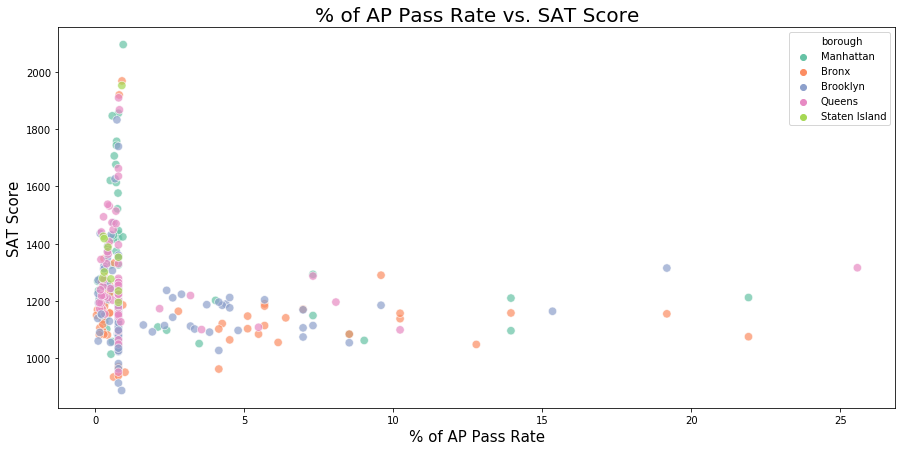

In [23]:
df['ap_pass_per']=df['Number of Exams with scores 3 4 or 5']/df['Total Exams Taken']

fig = plt.figure(figsize=(15,7))

cmap = sns.cubehelix_palette(dark=.5, light=.6, as_cmap=True)
ax = sns.scatterplot(x='ap_pass_per', y="sat_score",
                    hue="borough", 
                    palette="Set2",
                    s=70,
                    alpha=0.7,
                    data=df)

ax.set_title("% of AP Pass Rate vs. SAT Score", fontsize=20)
ax.set_xlabel("% of AP Pass Rate", fontsize=15)
ax.set_ylabel('SAT Score', fontsize=15)
plt.show()

Oddly, there is no relationship between AP pass rate with SAT score. Schools with 'high' AP pass rate all have SAT score less than 1400. On the flip side, all the schools have SAT score greater than 1800 have very low AP pass rate.

# Class Size vs. SAT Score

0.3810143308095523


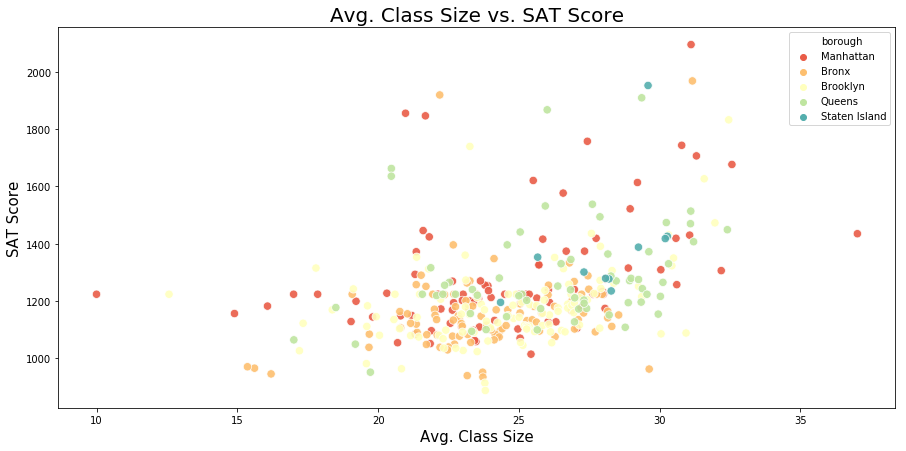

In [24]:
print(correlations['AVERAGE CLASS SIZE'])

fig = plt.figure(figsize=(15,7))

cmap = sns.cubehelix_palette(dark=.9, light=.9, as_cmap=True)
ax = sns.scatterplot(x='AVERAGE CLASS SIZE', y="sat_score",
                    hue="borough", 
                    palette="Spectral",
                    s=70,
                    alpha=0.9,
                    data=df)

ax.set_title("Avg. Class Size vs. SAT Score", fontsize=20)
ax.set_xlabel("Avg. Class Size", fontsize=15)
ax.set_ylabel('SAT Score', fontsize=15)
plt.show()

# Neighborhoods with Highest SAT Score

In [25]:
pd.pivot_table(df,index=["NTA"],values=["sat_score"],aggfunc=np.mean).sort_values(by='sat_score',ascending=False).head(10)

,sat_score
NTA,
Sheepshead Bay-Gerritsen Beach-Manhattan Beach,1627.000000
New Dorp-Midland Beach,1615.000000
Jamaica,1545.719403
Pomonok-Flushing Heights-Hillcrest,1538.000000
Oakland Gardens,1514.000000
Flatbush,1473.000000
Kew Gardens Hills,1469.750000
Auburndale,1457.500000
Fort Greene,1453.500000
